<a href="https://colab.research.google.com/github/lmendezayl/uba-ldd-tp1/blob/main/TP_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Práctico 1 - Laboratorio de Datos - 1C 2025

**Integrantes del grupo:**
- Lautaro Evaristo Mendez
- Franco Zalazar
- Luca Petrarca

In [2]:
# Si requieren mas librerias, pueden importarlas aca
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import seaborn.objects as so
import json
import plotly.express as px
from formulaic import Formula
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error

# Si no existe root_mean_squared_error, quitarlo o actualizar scikit-learn con el comando
#!pip install scikit-learn --upgrade

Trabajaremos con el dataset `indicadores-proceso-trayectoria-sobreedad-2012_2022.csv1` que
contiene mediciones de variables educativas de la escuela primaria y secundaria en la Provincia de Buenos Aires (PBA) desde 2012 a 2022. En este [link](https://abc.gob.ar/secretarias/sites/default/files/2021-08/MANUAL%20METODOLÓGICO%20DE%20INDICADORES%20EDUCATIVOS-%202021.pdf) pueden consultar la descripción de cada variable.

In [3]:
df_educacion = pd.read_csv('./indicadores-proceso-trayectoria-sobreedad-2012_2022.csv')
df_educacion.head()

,anio,municipio_id,municipio_nombre,promocion_efectiva_primaria,promocion_efectiva_secundaria,repitencia_primaria,repitencia_secundaria,reinscripcion_primaria,reinscripcion_secundaria,abandono_interanual_primaria,...,alumnos_no_promovidos_primaria,alumnos_no_promovidos_secundaria,salidos_sin_pase_primaria,salidos_sin_pase_secundaria,salidos_con_pase_primaria,salidos_con_pase_secundaria,sobreedad_primaria,sobreedad_secundaria,sobreedad_avanzada_primaria,sobreedad_avanzada_secundaria
0,2012,6007,Adolfo Alsina,100.26,84.14,1.25,9.06,0.07,1.79,-1.57,...,1.45,18.54,0.00,2.71,5.40,2.90,12.61,26.77,4.01,12.28
1,2013,6007,Adolfo Alsina,97.35,86.84,1.68,5.31,0.13,0.12,0.84,...,0.70,9.48,0.30,2.77,5.02,5.72,10.27,26.27,3.42,11.51
2,2014,6007,Adolfo Alsina,97.36,80.79,2.23,2.52,0.07,0.43,0.34,...,0.69,9.13,0.13,2.11,4.84,4.31,8.46,25.06,2.51,9.17
3,2015,6007,Adolfo Alsina,96.00,91.55,2.41,5.24,0.21,0.85,1.38,...,1.47,8.62,0.33,2.49,4.96,4.64,7.16,30.85,1.86,10.51
4,2016,6007,Adolfo Alsina,97.67,95.56,2.61,7.27,0.07,1.29,-0.35,...,1.58,6.95,0.14,2.79,4.72,3.57,6.81,26.13,1.69,8.24


### Procesamiento de Datos

En esta primera sección, vamos implementar algunas acciones básicas de procesamiento de nuestros datos

#### Ejercicio 1
Describir el tipo de variable de cada columna

Descripcion de las columnas y sus tipo de datos:

- `anio`: año en el que se realizo la medicion. Es de tipo `int`.

- `municipio_id`: numero de identificacion de cada municipio. Es de tipo `int`.
- `municipio_nombre`: nombre del municipio. Es de tipo `string`. (dice`object` pero bueno).

Las siguientes columnas reemplazan la `X` por `primaria` o por `secundaria`:
- `promocion_efectiva_X`: porcentaje de alumnos que aprobaron las materias y pasaron de grado.  Tipo `float`.
    - Se calcula  `promocion_efectiva_X = 100 - repitencia_X - reinscripcion_X - abandono_interanual_X`.
  
- `repitencia_X`: porcentaje de alumnos que repitieron grado. Tipo `float`.
- `reinscripcion_X`: porcentaje de alumnos que dejaron los estudios y se reincoporaron al sistema. Tipo `float`.
- `alumnos_promovidos_X`: porcentaje de alumnos que pasaron de grado. Tipo `float`.

El siguiente grupo de indicadores de medición permiten medir la eficiencia de la propia escuela, basadas a partir de nuevas preguntas incluidas en los cuadernillos del Relevamiento Anual y los Relevamientos provinciales de la PBA:

- `alumnos_promovidos_X`: porcentaje de alumnos que pasaron de grado. Tipo `float`.
    - Se calcula como `alumnos_promovidos_X = 100 - alumnos_no_promovidos_X`.
    - A diferencia del indicador tradicional de tasa de egreso (según su fórmula de cálculo, estima la probabilidad de egreso de un estudiante), este indicador mide qué porcentaje de estudiantes que asistieron hasta el último día de clases aprobaron todas las materias, ya sea en el mes de diciembre o en el período complementario de los meses de enero o febrero del año siguiente.

- `alumnos_no_promovidos_X`: porcentaje de alumnos que no pasaron de grado (similar a una tasa de repetidores anual). Tipo `float`.
- `salidos_sin_pase_X`: (equivalente a una tasa de abandono anual)
- `salidos_con_pase_X`: editar, no entiendo a que se referiria con pase, quizas se refiere al % de abandono considerando alumnos que se cambiaron de colegio??
- `sobreedad_X`: porcentaje de alumnos atrasados en su trayectoria escolar. Tipo `float`.
- `sobreedad_avanzada_X`: incluye sólo a los estudiantes que tienen dos o más años de atraso en su trayectoria escolar. Tipo `float`.

    - Se considera un recorte de `sobreedad_X`, ya que permite estimar una sobreedad neta porque algunos estudiantes tienen un año de sobreedad sólo por una diferencia de días o meses de nacimiento respecto de la edad mínima de ingreso a la escuela según la normativa.





#### Ejercicio 2
¿La base de datos contiene datos faltantes? ¿Cuántos?

In [4]:
df_educacion.isna().sum()

anio                                0
municipio_id                        0
municipio_nombre                    0
promocion_efectiva_primaria         0
promocion_efectiva_secundaria       0
repitencia_primaria                 0
repitencia_secundaria               0
reinscripcion_primaria              0
reinscripcion_secundaria            0
abandono_interanual_primaria        0
abandono_interanual_secundaria      0
alumnos_promovidos_primaria         0
alumnos_promovidos_secundaria       0
alumnos_no_promovidos_primaria      0
alumnos_no_promovidos_secundaria    0
salidos_sin_pase_primaria           0
salidos_sin_pase_secundaria         0
salidos_con_pase_primaria           0
salidos_con_pase_secundaria         0
sobreedad_primaria                  0
sobreedad_secundaria                0
sobreedad_avanzada_primaria         0
sobreedad_avanzada_secundaria       0
dtype: int64

La base de datos no contiene ningun dato faltante!

#### Ejercicio 3
Además de la división por municipio, nos interesa saber a que zona de la provincia pertenece cada municipio (Zona Norte, Zona Oeste , Zona Sur e Interior). Para esto:
1. Implementar una función `determinar_zona` que, dado el nombre de un municipio, devuelva a que zona pertencece: ’Norte’, ’Oeste’, ’Sur’ o ’Interior’.
2. Agregar la columna zona a `df_educacion` que contenga la zona a la que pertenece el
municipio.
*Sugerencia*: tener en cuenta el método `apply`

In [5]:
def determinar_zona(municipio_nombre: str) -> str:
    zona_norte = ['San Isidro', 'Vicente Lopez', 'General San Martin', 'San Fernando', 'Tigre']
    zona_oeste = ['Moron', 'Tres de Febrero', 'La Matanza', 'Merlo', 'Moreno']
    zona_sur = ['Almirante Brown', 'Avellaneda', 'Quilmes', 'Lanus', 'Florencio Varela', 'Berazategui', 'Lomas de Zamora', 'Esteban Echeverria']
    zonas = {
        "Norte" : zona_norte,
        "Sur" : zona_sur,
        "Oeste" : zona_oeste}

    for zona in zonas.keys():
        if municipio_nombre in zonas[zona]:
            return zona
    return "Interior"

zonas_test = ["San Isidro", "Vicente Lopez", "Merlo", "Avellaneda", "Guernica"]
for zona in zonas_test:
    print(determinar_zona(zona))

Norte
Norte
Oeste
Sur
Interior


In [6]:
df_educacion["zona"] = df_educacion["municipio_nombre"].apply(determinar_zona)
df_educacion.head()

,anio,municipio_id,municipio_nombre,promocion_efectiva_primaria,promocion_efectiva_secundaria,repitencia_primaria,repitencia_secundaria,reinscripcion_primaria,reinscripcion_secundaria,abandono_interanual_primaria,...,alumnos_no_promovidos_secundaria,salidos_sin_pase_primaria,salidos_sin_pase_secundaria,salidos_con_pase_primaria,salidos_con_pase_secundaria,sobreedad_primaria,sobreedad_secundaria,sobreedad_avanzada_primaria,sobreedad_avanzada_secundaria,zona
0,2012,6007,Adolfo Alsina,100.26,84.14,1.25,9.06,0.07,1.79,-1.57,...,18.54,0.00,2.71,5.40,2.90,12.61,26.77,4.01,12.28,Interior
1,2013,6007,Adolfo Alsina,97.35,86.84,1.68,5.31,0.13,0.12,0.84,...,9.48,0.30,2.77,5.02,5.72,10.27,26.27,3.42,11.51,Interior
2,2014,6007,Adolfo Alsina,97.36,80.79,2.23,2.52,0.07,0.43,0.34,...,9.13,0.13,2.11,4.84,4.31,8.46,25.06,2.51,9.17,Interior
3,2015,6007,Adolfo Alsina,96.00,91.55,2.41,5.24,0.21,0.85,1.38,...,8.62,0.33,2.49,4.96,4.64,7.16,30.85,1.86,10.51,Interior
4,2016,6007,Adolfo Alsina,97.67,95.56,2.61,7.27,0.07,1.29,-0.35,...,6.95,0.14,2.79,4.72,3.57,6.81,26.13,1.69,8.24,Interior


#### Ejercicio 4

Quisiéramos analizar si en general la tasa de repitencia es más alta en primaria que en secundaria. Para esto:
1. Agregar una columna `mayor_repitencia_primaria` a `df_educacion` que indique si ocurre
esta situación.
2. Mostrar en una Serie de `pandas` cuantas veces entre los años 2017 y 2022 (inclusive) la repitencia es más alta en primaria que en secundaria para cada municipio.
3. Mostrar en un DataFrame la media de repitencia en primaria y la media de repitencia en secundaria agrupados por año y por zona.

In [7]:
# 1
df_educacion['mayor_repitencia_primaria'] = df_educacion['repitencia_primaria'] > df_educacion['repitencia_secundaria']
df_educacion.head()

,anio,municipio_id,municipio_nombre,promocion_efectiva_primaria,promocion_efectiva_secundaria,repitencia_primaria,repitencia_secundaria,reinscripcion_primaria,reinscripcion_secundaria,abandono_interanual_primaria,...,salidos_sin_pase_primaria,salidos_sin_pase_secundaria,salidos_con_pase_primaria,salidos_con_pase_secundaria,sobreedad_primaria,sobreedad_secundaria,sobreedad_avanzada_primaria,sobreedad_avanzada_secundaria,zona,mayor_repitencia_primaria
0,2012,6007,Adolfo Alsina,100.26,84.14,1.25,9.06,0.07,1.79,-1.57,...,0.00,2.71,5.40,2.90,12.61,26.77,4.01,12.28,Interior,False
1,2013,6007,Adolfo Alsina,97.35,86.84,1.68,5.31,0.13,0.12,0.84,...,0.30,2.77,5.02,5.72,10.27,26.27,3.42,11.51,Interior,False
2,2014,6007,Adolfo Alsina,97.36,80.79,2.23,2.52,0.07,0.43,0.34,...,0.13,2.11,4.84,4.31,8.46,25.06,2.51,9.17,Interior,False
3,2015,6007,Adolfo Alsina,96.00,91.55,2.41,5.24,0.21,0.85,1.38,...,0.33,2.49,4.96,4.64,7.16,30.85,1.86,10.51,Interior,False
4,2016,6007,Adolfo Alsina,97.67,95.56,2.61,7.27,0.07,1.29,-0.35,...,0.14,2.79,4.72,3.57,6.81,26.13,1.69,8.24,Interior,False


In [ ]:
# 2
municipios = df_educacion['municipio_nombre'].unique() # array de todos los municipios
df_educacion_2017_2022 = df_educacion[df_educacion['anio'] >= 2017] # no hace falta poner que es menor que 2022 ya que es el maximo del conjunto de años.
cant_repitencia_2017_2022 = pd.Series()

for municipio in municipios:
    # dataframe temporal, siempre que se llame df_cache
    df_cache = df_educacion_2017_2022[df_educacion_2017_2022['municipio_nombre'] == municipio]
    cant_repitencia_2017_2022[municipio] = np.sum(df_cache['mayor_repitencia_primaria'])

cant_repitencia_2017_2022

Adolfo Alsina      1
Alberti            1
Almirante Brown    1
Arrecifes          1
Avellaneda         1
                  ..
25 de Mayo         1
Vicente Lopez      1
Villa Gesell       2
Villarino          1
Zarate             1
Length: 135, dtype: int64

In [50]:
# 3

df_media_repitencia = (
    df_educacion
    .groupby(['anio', 'zona'])
    .agg({
        'repitencia_primaria': 'mean',
        'repitencia_secundaria': 'mean'
        })
    .reset_index()
    .rename(columns={
        'repitencia_primaria': 'media_repitencia_primaria',
        'repitencia_secundaria': 'media_repitencia_secundaria'
        })
)
df_media_repitencia.head()

,anio,zona,media_repitencia_primaria,media_repitencia_secundaria
0,2012,Interior,2.457350,10.699316
1,2012,Norte,1.634000,8.978000
2,2012,Oeste,2.346000,9.932000
3,2012,Sur,2.470000,10.208750
4,2013,Interior,1.771368,10.499402


### Regresión
En esta sección, sugerimos que, una vez realizada una Regresión, utilicen los valores de $β_0$ y $β_1$ para predecir, en vez del método `predict` de `scikit-learn`.

#### Ejercicio 1
Reproducir el siguiente gráfico sobre la evolución de la sobreedad en secundaria promedio en la Provincia de Buenos Aires a lo largo de los años:

In [82]:
df_media_sobreedad_secundaria = df_educacion[['anio', 'sobreedad_secundaria']].copy()
df_media_sobreedad_secundaria = (
    df_media_sobreedad_secundaria
    .groupby(["anio"])
    .mean()
    .reset_index()
    .rename(columns={'sobreedad_secundaria' : 'sobreedad'})
)
df_media_sobreedad_secundaria

,anio,sobreedad
0,2012,35.344074
1,2013,32.554889
2,2014,31.719704
3,2015,30.535333
4,2016,29.719556
5,2017,28.883259
6,2018,27.584370
7,2019,26.282370
8,2020,24.578519
9,2021,22.097556


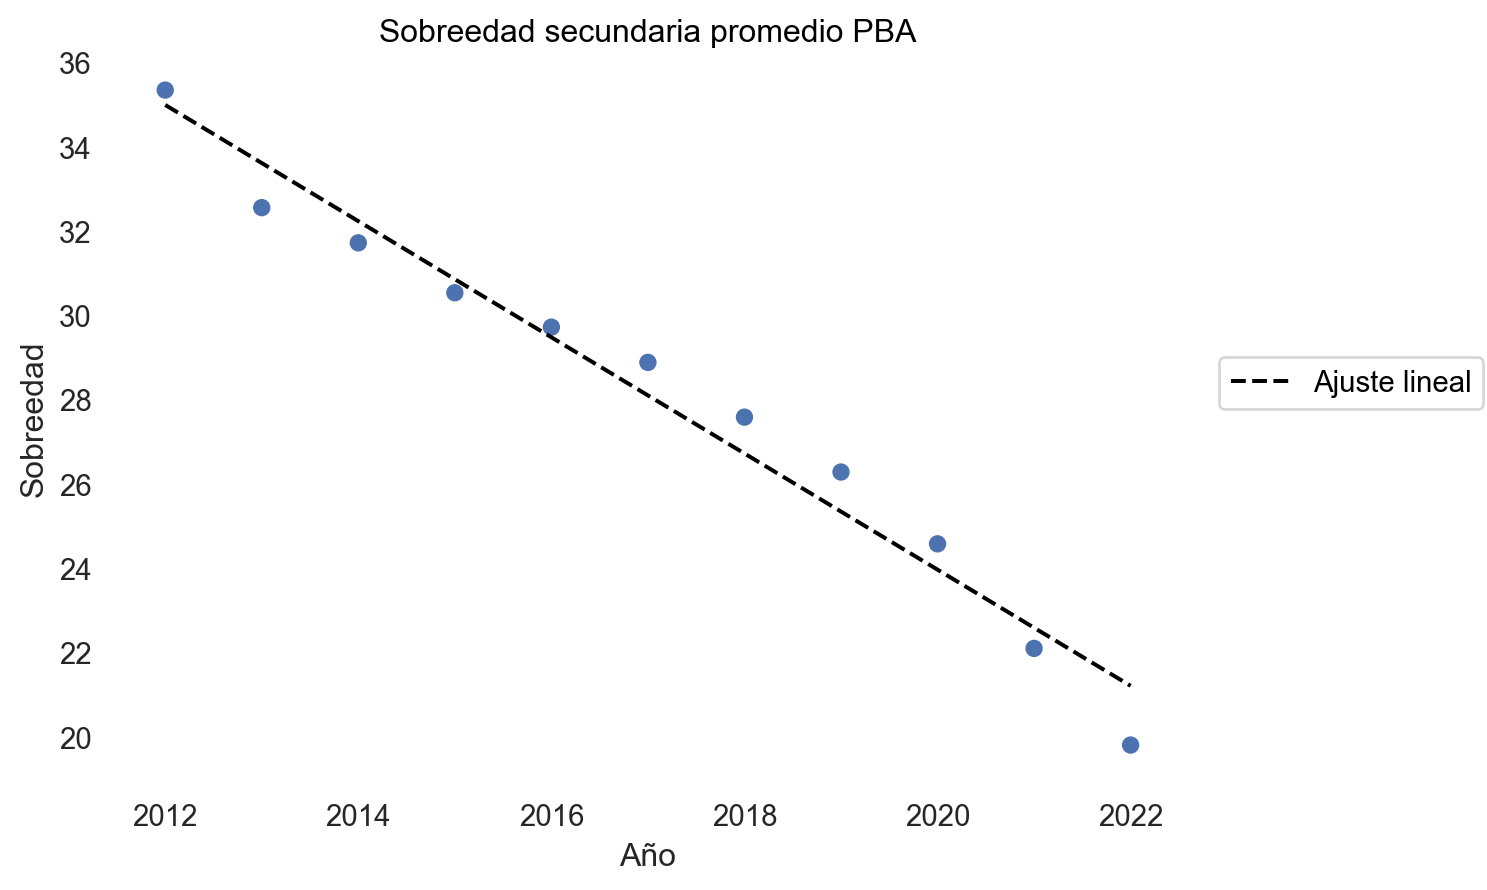

In [83]:
(
    so.Plot(data=df_media_sobreedad_secundaria, 
            x=df_media_sobreedad_secundaria["anio"],
            y=df_media_sobreedad_secundaria["sobreedad"])
    .add(so.Line(linestyle='dashed', color="black"), so.PolyFit(1), label="Ajuste lineal")
    .add(so.Dot())
    .label(
        title="Sobreedad secundaria promedio PBA",
        x="Año",
        y="Sobreedad",   
    )
    .theme({"axes.facecolor": "w"}) # lo tuve que buscar: https://seaborn.pydata.org/generated/seaborn.objects.Plot.theme.html
)

#### Ejercicio 2
Realizando una Regresión Lineal, predecir para el año 2025 la sobreedad en secundaria promedio en la Provincia de Buenos Aires

In [100]:
y, X = Formula('anio ~ sobreedad').get_model_matrix(df_media_sobreedad_secundaria)
modelo = linear_model.LinearRegression(fit_intercept=False)
modelo.fit(X, y)
beta = modelo.coef_[0]
beta[0]

np.float64(2036.775658309628)

#### Ejercicio 3
Para cada municipio del Área Metropolitana, mediante Regresión Lineal, predecir la sobreedad en secundaria para el 2025. Elaborar un DataFrame indexado por el nombre del municipio, con dos columnas: `sobreedad_2025` con el resultado de la predicción para 2025
y `menor_que_promedio` que indique con un booleano si la predicción es menor al valor calculado en el ítem anterior.

**Sugerencia**: puede basarse en la siguiente estructura


In [10]:
"""
prediccion_data = []
menor_que_promedio_data = []
for partido in area_metropolitana:
    #########################
    # Realizar la regresion #
    #########################
    prediccion_data.append(???)
    mejor_que_promedio_data.append(???)
predicciones_df = pd.DataFrame(
    data = {'prediccion_2025': ???, 'mejor_que_promedio': ???},
    index = ???
)
"""

"\nprediccion_data = []\nmenor_que_promedio_data = []\nfor partido in area_metropolitana:\n    #########################\n    # Realizar la regresion #\n    #########################\n    prediccion_data.append(???)\n    mejor_que_promedio_data.append(???)\npredicciones_df = pd.DataFrame(\n    data = {'prediccion_2025': ???, 'mejor_que_promedio': ???},\n    index = ???\n)\n"

In [11]:
area_metropolitana = ['Almirante Brown', 'Avellaneda', 'Berazategui', 'Berisso', 'Brandsen', 'Campana', 'Cañuelas',
                      'Ensenada', 'Escobar', 'Esteban Echeverria', 'Exaltacion de la Cruz', 'Ezeiza',
                      'Florencio Varela', 'General Las Heras', 'General Rodriguez', 'General San Martin', 'Hurlingham',
                      'Ituzaingo', 'Jose C. Paz', 'La Matanza', 'La Plata', 'Lanus', 'Lujan', 'Lomas de Zamora',
                      'Malvinas Argentinas', 'Marcos Paz', 'Merlo', 'Moreno', 'Moron', 'Pilar', 'Presidente Peron',
                      'Quilmes', 'San Fernando', 'San Isidro', 'San Miguel', 'San Vicente', 'Tigre', 'Tres de Febrero',
                      'Vicente Lopez', 'Zarate']

### Visualización con datos geográficos
El objetivo de esta parte del TP es visualizar datos sobre un mapa de Buenos Aires. Para esto, utilizaremos las librerías `geopandas`, que nos permite trabajar con un .geojson como si fuera un DataFrame de `pandas`, y `plotly` para generar mapas interactivos

#### Ejercicio 1
Cargar los datos de `partidos.geojson` utilizando `geopandas`:



In [12]:
# Cargamos el archivo de datos
geo_df = gpd.read_file('partidos.geojson')


Si imprimimos `geo_df` observamos que cada fila corresponde a un municipio con distintas
características y, además, hay una columna `geometry` que tiene las coordenadas de los límites de los partidos. Pueden visualizar estos datos con `geo_df.plot()`.

<Axes: >

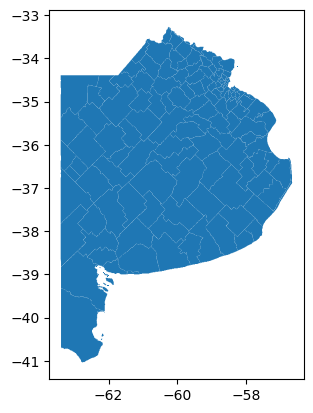

In [13]:
# Visualizamos los partidos
geo_df.plot()

#### Ejercicio 2
Identificar qué columna se corresponde al número de identificación de cada municipio. Mostrar
todos los municipios con números de identificación repetidos.
**Sugerencia**: utilizar el argumento `keep` del método `duplicated`

#### Ejercicio 3
Aplicar las siguientes modificaciones a `geo_df`:
1. eliminar las filas que correspondan a islas de partidos (por ejemplo, Islas Ramallo).
2. convertir la columna `cde` a numérica (recordar el método `astype`)
3. corregir los valores en la columna cde para los partidos de Chascomús y Lezama, para
que coincidan con sus valores en la columna `municipio_id` de `df_educacion`. **Sugerencia**: puede basarse en el siguiente código para corregir los valores:

`geo_df.loc[geo_df[???] == ???, <columna a modificar>] = ???`

Finalmente, exportar `geo_df` como un GeoJSON llamado `partidos_limpio.geojson`:

In [14]:
# Grabamos los datos limpios en un nuevo archivo GeoJSON
geo_df.to_file('partidos_limpio.geojson', driver='GeoJSON')

In [15]:
# Limpieza de datos. Seguir las indicaciones en la consigna del TP para este paso.


#### Ejercicio 4
A partir del DataFrame `df_educacion`, crear un DataFrame `repit` que tenga tres colum-
nas: `cde` con el código del municipio, `municipio_nombre` con el nombre del municipio y
`repitencia_secundaria` con el promedio de repitencia en secundaria del municipio.

**Sugerencia**: Partir de `df_educacion.groupby(['municipio_id', 'municipio_nombre'])`.
Si obtienen una serie con multi-indices, pueden convertirlo a DataFrame con columnas para los índices utilizando `.reset_index()`. O si ingresan el nombre de la columna `repitencia_secundaria` entre doble corchetes, obtienen también un DataFrame con las tres columnas

In [16]:
# Creamos un DataFrame repit con los datos de repitencia siguiendo la consigna del TP





#### Ejercicio 5
Con el siguiente código podemos elaborar un mapa interactivo:

In [17]:
with open('partidos_limpio.geojson', 'r') as f:
    partidos = json.load(f)

fig = px.choropleth_map(
    repit,
    geojson=partidos,
    featureidkey = 'properties.cde',
    locations='cde',
    color='repitencia_secundaria',
    zoom = 4,
    center = {"lat": -34.61315, "lon": -58.37723},
)

fig.show()

NameError: name 'repit' is not defined

Agregar argumentos a `choropleth_map` para que:
1. la escala de color sea 'Bluered' (pueden ver otras escalas de color en este link)
2. la opacidad del color sea de 0.7
3. que al pasar el cursor sobre un partido, se muestre también su nombre

In [ ]:
# Generamos un gráfico interactivo para el nivel de repitencia

# Si no existe chorpleth_map o alguna opcion del codigo en la siguiente celda, actualizar plotly con el siguiente comando y reiniciar el kernel.
#!pip install plotly --upgrade

# Si tienen algún error de Java después de instalar los paquetes actualizados y reiniciar el kernel, prueben refrescar el navegador con CTRL+F5.

### Análisis exploratorio

La idea de este ítem es que realicen un análisis exploratorio de los datos, aplicando las herramientas de visualización (seaborn.objects, seaborn y/o matplotlib), de resumen de datos (media, mediana, desvío estándar, operaciones sobre el DataFrame, etc.) y/o de Regresión.
El objetivo es entender, comparar y/o estudiar aspectos en los indicadores educativos de los partidos de la Provincia de Buenos Aires. Algunas preguntas disparadoras pueden ser:
- ¿Existe alguna relación entre la repitencia y los fondos enviados al partido para la educación?
- ¿Podemos explicar por qué hay algunos partidos con repitencia muy superior al promedio?
- ¿Qué relación hay entre la cantidad de habitantes y la cantidad de establecimientos educativos?
-
No es necesario que respondan a cada una de esas preguntas (ni se limiten a eso), lo mejor es que exploren por donde se les ocurra. Alentamos que se planteen hipótesis y usen los datos para corroborarlas o rechazarlas. Pueden aplicar cualquiera de las herramientas que hemos visto hasta ahora. Asimismo, pueden centrarse en un conjunto de partidos, en un conjunto de indicadores educativos, etc.

A continuación dejamos otros datasets que pueden serles de ayuda (su uso es opcional):
- [Establecimientos educativos](https://catalogo.datos.gba.gob.ar/dataset/establecimientos-educativos)
- [Población](https://catalogo.datos.gba.gob.ar/dataset/poblacion)
- [Transferencias a Consejos Escolares](https://catalogo.datos.gba.gob.ar/dataset/tranferencias-consejos-escolares)
- [Transferencias a municipios](https://catalogo.datos.gba.gob.ar/dataset/transferencias-municipios)

También pueden explorar datasets del Gobierno Nacional o de la Ciudad de Buenos Aires (pero
que el análisis esté centrado en PBA).


**Importante**: en el Notebook, las visualizaciones y resúmenes de datos que realicen deben
estar acompañados por las conclusiones que obtengan a partir de ellos.